# <center> $$Catboost\ hyperparameters\ tuning$$

## 1.  Connecting to GitHub and installing libraries


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/1_NYC_taxi/

/content/drive/MyDrive/1_NYC_taxi


In [ ]:
!pip install catboost==1.0.6
!pip install PyYAML==6.0
!pip install optuna==2.10.1
!pip install shap==0.41.0
!pip install scikit-learn==1.0.1

In [ ]:
import pandas as pd

In [ ]:
github_invite = pd.read_csv('github_invite.csv')
user = github_invite['user'][0]
repo = github_invite['repo'][0]
token = github_invite['token'][0]

!git clone https://{token}@github.com/{user}/{repo}

Cloning into 'nyc_taxi_trip_proj'...
remote: Enumerating objects: 254, done.
remote: Counting objects: 100% (254/254), done.
remote: Compressing objects: 100% (179/179), done.
remote: Total 254 (delta 93), reused 210 (delta 52), pack-reused 0
Receiving objects: 100% (254/254), 12.67 MiB | 5.10 MiB/s, done.
Resolving deltas: 100% (93/93), done.


In [ ]:
%cd nyc_taxi_trip_proj/backend/notebooks/

/content/drive/MyDrive/1_NYC_taxi/nyc_taxi_trip_proj/backend/notebooks


In [ ]:
import yaml
import shap
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from optuna import create_study
from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import sys
sys.path.append('../')
from src import clean_data, get_data, add_features, import_config

# 2. Data Preprocessing

In [ ]:
!pwd

/content/drive/MyDrive/1_NYC_taxi/nyc_taxi_trip_proj/backend/notebooks


In [ ]:
# config
cfg = import_config('../config/params.yaml')
test_size = cfg['data_split']['test_size']
test_split_seed = cfg['data_split']['test_split_seed']
valid_size = cfg['data_split']['valid_size']
valid_split_seed = cfg['data_split']['valid_split_seed']

In [ ]:
# data preprocessing
path = 'https://github.com/EuMentality/datasets/raw/main/taxi_trip.csv'
df = add_features(clean_data(get_data(path)), path_kmeans='../model/kmeans.pkl', purpose='tuning')

In [ ]:
# processing for tuning & testing
X = df.drop('trip_duration', axis=1)
y = df.trip_duration

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=test_split_seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=valid_size, random_state=valid_split_seed)

print(f'train shape == {X_train.shape}')
print(f'validation shape == {X_val.shape}')
print(f'test shape == {X_test.shape}')
cat_feature_indices = np.array([0, 5, 6, 7, 8, 9, 11]) 
train_pool = Pool(X_train, y_train, cat_features=cat_feature_indices)
val_pool = Pool(X_val, y_val, cat_features=cat_feature_indices)
test_pool = Pool(X_test, y_test, cat_features=cat_feature_indices)

train shape == (363202, 12)
validation shape == (90801, 12)
test shape == (113501, 12)


# 3. Catboost tuning

## 3.1 Best Params Searching

In [ ]:
params_defolt = {
                'iterations': 1500,
                'boosting_type': 'Plain',
                'bootstrap_type': 'Bernoulli',
                'use_best_model': True,
                'verbose': False,
                'task_type': 'GPU',
                'random_state': 20
                }

In [ ]:
def objective(trial):
    params_search = {
        "learning_rate": trial.suggest_uniform("learning_rate", 1e-3, 1e-1), 
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 2e-1, 20e0),
        # "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1.0), 
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "depth": trial.suggest_int("depth", 4, 16)
        }

    model = CatBoostRegressor(**params_defolt, **params_search)
    model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=30)
    print(f"N trees = {model.tree_count_}")
    y_pred = model.predict(X_test)
    score = mean_squared_error(y_test, y_pred, squared=False)
    return score

In [ ]:
%%time
study = create_study(sampler=TPESampler(), direction="minimize")
study.optimize(objective, n_trials=50)

In [19]:
# Best Params
print("Number of completed trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("\tBest Score: {}".format(trial.value))
print("\tBest Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of completed trials: 50
Best trial:
	Best Score: 0.35382773057082506
	Best Params: 
    learning_rate: 0.07433145899644433
    l2_leaf_reg: 0.5639030283061931
    subsample: 0.9217285030632677
    depth: 11


In [20]:
# updating params
for key, value in trial.params.items():
    params_defolt[key] = value

## 3.2 Finding N Estimators

In [82]:
params_defolt['iterations'] = 2500

In [83]:
catboost_final = CatBoostRegressor(**params_defolt)
catboost_final.fit(train_pool, eval_set=val_pool,early_stopping_rounds=30, verbose=300)
n_estimators = catboost_final.tree_count_

0:	learn: 0.6672303	test: 0.6656414	best: 0.6656414 (0)	total: 165ms	remaining: 6m 51s
300:	learn: 0.3342476	test: 0.3625359	best: 0.3625359 (300)	total: 22.1s	remaining: 2m 41s
600:	learn: 0.3080431	test: 0.3573120	best: 0.3573120 (600)	total: 43.1s	remaining: 2m 16s
900:	learn: 0.2903495	test: 0.3549130	best: 0.3549130 (900)	total: 1m 4s	remaining: 1m 54s
1200:	learn: 0.2759500	test: 0.3534348	best: 0.3534348 (1200)	total: 1m 26s	remaining: 1m 33s
1500:	learn: 0.2633299	test: 0.3524777	best: 0.3524777 (1500)	total: 1m 50s	remaining: 1m 13s
1800:	learn: 0.2530510	test: 0.3518083	best: 0.3518083 (1800)	total: 2m 11s	remaining: 51.2s
bestTest = 0.3517112285
bestIteration = 1892


In [85]:
print(f'Best number of trees = {n_estimators}')

Best number of trees = 1923


In [86]:
params_defolt['iterations'] = n_estimators
params_defolt['use_best_model'] = False
best_params = params_defolt

In [87]:
best_params

{'boosting_type': 'Plain',
 'bootstrap_type': 'Bernoulli',
 'depth': 11,
 'iterations': 1923,
 'l2_leaf_reg': 0.5639030283061931,
 'learning_rate': 0.07433145899644433,
 'random_state': 20,
 'subsample': 0.9217285030632677,
 'task_type': 'GPU',
 'use_best_model': False,
 'verbose': False}

## 4. Model Quality Estimation

In [88]:
X_train_last = pd.concat([X_train, X_val])
y_train_last = pd.concat([y_train, y_val])
train_pool_last = Pool(X_train_last, y_train_last, cat_features=cat_feature_indices)

In [89]:
best_catboost = CatBoostRegressor(**best_params)
best_catboost.fit(train_pool_last)

In [90]:
y_test_predict = best_catboost.predict(X_test)
y_train_predict = best_catboost.predict(X_train)

In [91]:
from sklearn.metrics import mean_absolute_error

In [92]:
msle_train = np.round(mean_squared_error(y_train, y_train_predict), 2)
msle_test = np.round(mean_squared_error(y_test, y_test_predict), 2)

mae_minutes_train = np.round(mean_absolute_error(np.exp(y_train)/60, np.exp(y_train_predict)/60), 2)
mae_minutes_test = np.round(mean_absolute_error(np.exp(y_test)/60, np.exp(y_test_predict)/60), 2)

r2_train = np.round(r2_score(y_train, y_train_predict), 2)
r2_test = np.round(r2_score(y_test, y_test_predict), 2)

In [93]:
print(f'MSLE Train = {msle_train}')
print(f'MSLE Test = {msle_test}', '\n')
print(f'MAE in Minutes Train = {mae_minutes_train}')
print(f'MAE in Minutes Test = {mae_minutes_test}', '\n')
print(f'r2 Train = {r2_train}')
print(f'r2 Test = {r2_test}')

MSLE Train = 0.08
MSLE Test = 0.12 

MAE in Minutes Train = 2.27
MAE in Minutes Test = 2.42 

r2 Train = 0.84
r2 Test = 0.75


# 5. Feature Importance


## 5.1 Overall 
For each feature shows how much on average the prediction changes if the feature value changes. The bigger the value of the importance the bigger on average is the change to the prediction value, if this feature is changed. Feature importance values are normalized so that the sum of importances of all features is equal to 100

In [94]:
best_catboost.get_feature_importance(prettified=True)

,Feature Id,Importances
0,manh_length,25.384784
1,dropoff_latitude,12.344727
2,pickup_hour,11.602581
3,pickup_weekday,9.976103
4,pickup_longitude,8.648474
5,dropoff_longitude,8.624984
6,pickup_latitude,8.218366
7,pickup_month,6.654778
8,route,5.013296
9,high_traffic,3.278426


## 5.2 SHAP values
A vector with contributions of each feature to the prediction for every input object and the expected value of the model prediction for the object (average prediction given no knowledge about the object).

In [95]:
vals = np.random.randint(0, X.shape[0], size=1500)

In [96]:
explainer = shap.TreeExplainer(best_catboost)
shap_values = explainer.shap_values(Pool(X.iloc[vals, :], y[vals], cat_features=cat_feature_indices))

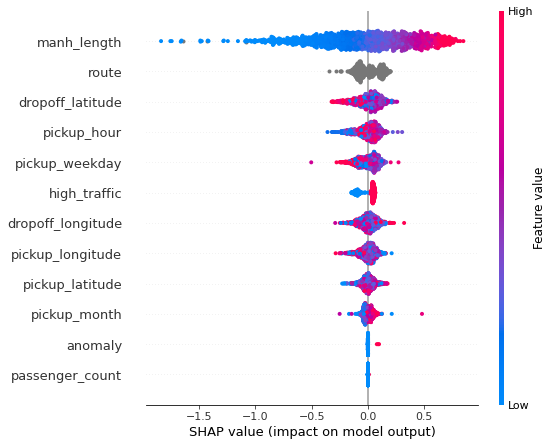

In [97]:
shap.summary_plot(shap_values, X.iloc[vals, :],)

## 6. Saving Params

In [98]:
with open('../config/params.yaml', 'w') as config:
    cfg['catboost'] = best_params
    yaml.safe_dump(cfg, config, default_flow_style=False)

In [99]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   ../config/params.yaml

no changes added to commit (use "git add" and/or "git commit -a")


In [ ]:
!git add .

In [ ]:
!git commit -m "add tuning"

[main a4d1bf7] add tuning
 1 file changed, 1 insertion(+), 1 deletion(-)


In [ ]:
!git push

Counting objects: 5, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 1.12 KiB | 191.00 KiB/s, done.
Total 5 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/EuMentality//nyc_taxi_trip_proj
   eab6e3c..a4d1bf7  main -> main
